In [4]:
import default_config as config
import newvae
import torch
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["GEOMSTATS_BACKEND"] = "pytorch"

from datasets.wiggles import Wiggles
from datasets.data_loader import TrainValLoader
import pandas as pd
import train

In [5]:
def get_immersion(model):

    def immersion(angle):
        z = torch.tensor([torch.cos(angle), torch.sin(angle)])
        x_rec = model.decode(z)
        return x_rec

    return immersion

In [6]:
def mean_curv(base_point, immersion, embedding_dim):
    H = torch.zeros(embedding_dim)
    for i in range(embedding_dim):
        H[i] = torch.autograd.functional.hessian(
            func=lambda x: immersion(x)[i], inputs=base_point
        )
    return H

In [7]:
def get_curv_profile(angles,model,embedding_dim):
    immersion = get_immersion(model)
    mean_curv_vecs = [mean_curv(angle,immersion,embedding_dim) for angle in angles]
    norms = [torch.linalg.norm(vec) for vec in mean_curv_vecs]
    return norms

In [8]:
def plot_model(thetas, model):
    immersion = get_immersion(model)
    z = [immersion(theta) for theta in thetas]
    x = [vec[0].detach().numpy() for vec in z]
    y = [vec[1].detach().numpy() for vec in z]
    plt.scatter(x,y,c=thetas)

In [9]:
model = newvae.VAE(
    input_dim=config.embedding_dim,
    encoder_dims=config.encoder_dims,
    latent_dim=config.latent_dim,
    latent_geometry=config.latent_geometry,
    decoder_dims=config.decoder_dims,
).to(config.device)

In [10]:
dataset = Wiggles(
    n_times=config.n_times,
    n_wiggles=config.n_wiggles,
    synth_radius=config.synth_radius,
    amp_wiggles=config.amp_wiggles,
    embedding_dim=config.embedding_dim,
    noise_var=config.noise_var,
    rotation=config.rotation,
)

In [11]:
#Normalize Data

dataset.data = dataset.data - dataset.data.min()
dataset.data = dataset.data / dataset.data.max()

In [12]:
data = dataset.data
labels = dataset.labels

labels = pd.DataFrame(
    {
        "angles": labels,
    }
)

data_loader = TrainValLoader(batch_size=config.batch_size)

data_loader.load(dataset)

train_loader = data_loader.train

test_loader = data_loader.val

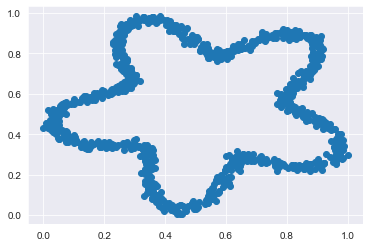

In [13]:
x=dataset.data[:,0]
y = dataset.data[:,1]
plt.scatter(x,y)

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)


losses = train.train_model(
    model, data, labels, train_loader, test_loader, optimizer, config
)

====> Epoch: 1 Average loss: 0.0369
====> Test set loss: 0.0368
====> Epoch: 2 Average loss: 0.0366
====> Test set loss: 0.0363
====> Epoch: 3 Average loss: 0.0360
====> Test set loss: 0.0358
====> Epoch: 4 Average loss: 0.0357
====> Test set loss: 0.0357
====> Epoch: 5 Average loss: 0.0357
====> Test set loss: 0.0357
====> Epoch: 6 Average loss: 0.0357
====> Test set loss: 0.0357
====> Epoch: 7 Average loss: 0.0357
====> Test set loss: 0.0357
====> Epoch: 8 Average loss: 0.0357
====> Test set loss: 0.0357
====> Epoch: 9 Average loss: 0.0357
====> Test set loss: 0.0357
====> Epoch: 10 Average loss: 0.0357
====> Test set loss: 0.0357
====> Epoch: 11 Average loss: 0.0357
====> Test set loss: 0.0357
====> Epoch: 12 Average loss: 0.0357
====> Test set loss: 0.0357
====> Epoch: 13 Average loss: 0.0357
====> Test set loss: 0.0357
====> Epoch: 14 Average loss: 0.0357
====> Test set loss: 0.0357
====> Epoch: 15 Average loss: 0.0357
====> Test set loss: 0.0357
====> Epoch: 16 Average loss: 0.03

In [15]:
angles = torch.linspace(0,2*torch.pi,1000)

norms = get_curv_profile(angles,model,config.embedding_dim)

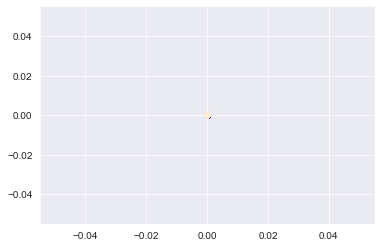

In [16]:
plot_model(angles, model)

In [17]:
model

VAE(
  (encoder_layers): ModuleList(
    (0): Linear(in_features=2, out_features=40, bias=True)
    (1): Linear(in_features=40, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=10, bias=True)
  )
  (distribution_param_layers): ModuleDict(
    (mu): Linear(in_features=10, out_features=2, bias=True)
    (kappa): Linear(in_features=10, out_features=1, bias=True)
  )
  (decoder_layers): ModuleList(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=40, bias=True)
    (4): Linear(in_features=40, out_features=2, bias=True)
  )
)

In [41]:
posterior_params, (q_z, p_z), z, x_rec = model(data)

<AxesSubplot:xlabel='z0', ylabel='z1'>

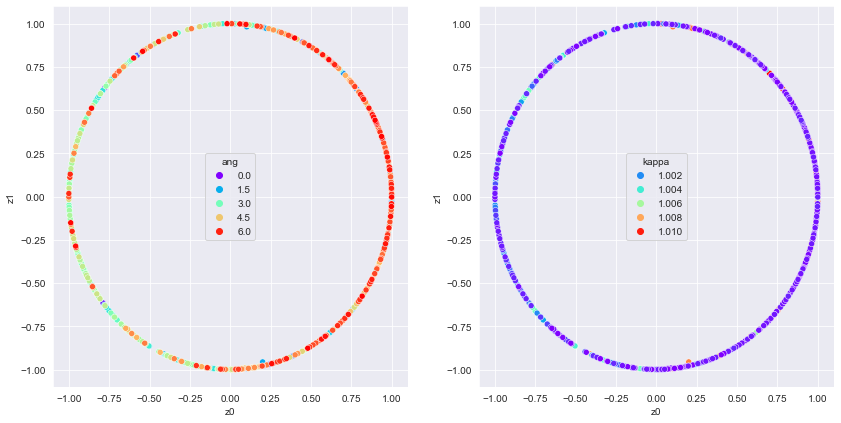

In [62]:

df_angles = pd.DataFrame({"z0": z[:,0].detach().numpy(),
        "z1": z[:,1].detach().numpy(),
        "ang" : labels["angles"]
    })

df_kappa = pd.DataFrame({"z0": z[:,0].detach().numpy(),
        "z1": z[:,1].detach().numpy(),
        "kappa" : torch.squeeze(posterior_params["kappa"]).detach().numpy()
    })



fig, axes = plt.subplots(1,2, figsize=(14,7))

sns.scatterplot(data=df_angles, x="z0", y="z1", hue="ang",palette="rainbow",ax=axes[0])
sns.scatterplot(data=df_kappa, x="z0", y="z1", hue="kappa",palette="rainbow",ax=axes[1])
